In [1]:
%load_ext rpy2.ipython
%R library(dplyr); library(ggplot2); library(magrittr); library(parody); library(reshape);library(grid); library(gridExtra)


Attaching package: ‘dplyr’

The following object is masked from ‘package:stats’:

    filter

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Attaching package: ‘reshape’

The following object is masked from ‘package:dplyr’:

    rename



<StrVector - Python:0x10a3b0fc8 / R:0x106eb5348>
[str, str, str, ..., str, str, str]

In [2]:
hosts=['Syn7803', 'VibPara', 'Msmeg155']
paccs=['NC_006820.1', 'NC_005083.2', 'JF937105.1']

     V6 NC_006820.1 Syn7803
AAA AAA           1       1
AAC AAC           1       1
AAG AAG           0       0
AAT AAT           0       0
ACA ACA           1       1
ACC ACC           0       1
Using V6 as id variables
   V6    variable value
1 AAA NC_006820.1     1
2 AAC NC_006820.1     1
3 ACA NC_006820.1     1
4 AGA NC_006820.1     1
5 AGC NC_006820.1     1
6 ATA NC_006820.1     1
     V6 NC_005083.2 VibPara
AAA AAA           2       4
AAC AAC           2       5
AAG AAG           0       0
AAT AAT           0       0
ACA ACA           1       5
ACC ACC           0       2
Using V6 as id variables
   V6    variable value
1 AAA NC_005083.2     2
2 AAC NC_005083.2     2
3 ACA NC_005083.2     1
4 AGA NC_005083.2     1
5 AGC NC_005083.2     1
6 ATC NC_005083.2     2
     V6 JF937105.1 Msmeg155
AAA AAA          0        1
AAC AAC          1        1
AAG AAG          1        1
AAT AAT          0        0
ACA ACA          0        1
ACC ACC          0        1
Using V6 as id variables
 

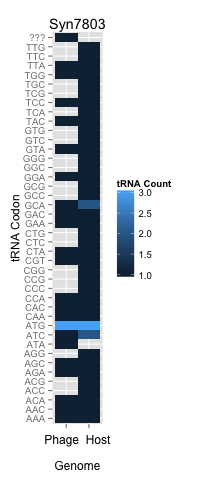

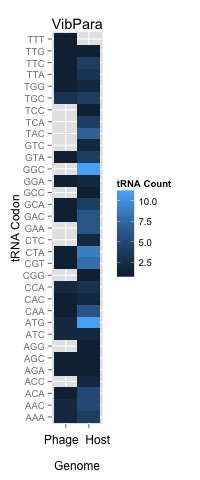

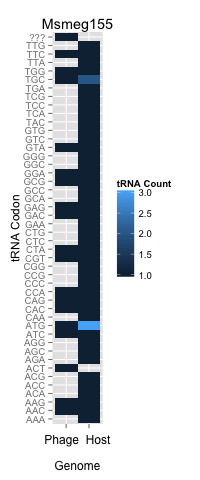

In [3]:
%%R -i hosts -i paccs -w 200

trna_file_path<-"./data/svm1/"

codons<-read.table("./data/codon_list.txt", header=FALSE)
colnames(codons)[2]<-"V6"

for (i in seq(1,3)){
    codons<-read.table("./data/codon_list.txt", header=FALSE)
    colnames(codons)[2]<-"V6"
    phage<-paccs[i]
    host<-hosts[i]
    
    ptrna<-read.table(paste(trna_file_path, phage, ".trna",sep=""), skip=3, header=FALSE,sep="\t")
    ptrna%>%group_by(V6)%>%summarise(count=n())->ptrna
    colnames(ptrna)[2]<-phage
    
    htrna<-read.table(paste(trna_file_path, host, ".trna",sep=""), skip=3, header=FALSE,sep="\t")
    htrna%>%group_by(V6)%>%summarise(count=n())->htrna
    colnames(htrna)[2]<-host
    
    codons<-merge(codons, ptrna, by="V6", all.x=TRUE, all.y=TRUE)
    codons<-merge(codons, htrna, by="V6", all.x=TRUE, all.y=TRUE)
    
    codons$V1<-NULL
    codons[is.na(codons)]<-0
    rownames(codons)<-codons$V6
    print(head(codons))
    codons%>%melt->ptmelt
    rmelt_nz<-filter(ptmelt, value>0)
    print(head(rmelt_nz))
    
    ggplot(rmelt_nz, aes(variable, V6))+geom_tile(data=rmelt_nz, aes(fill=value, position="identity"))->damnplot
    damnplot+labs(title=host, 
                  x="Phage  Host\n\nGenome", 
                  y="tRNA Codon", fill="tRNA Count")->damnplot
    damnplot<-damnplot+theme(axis.text.x = element_blank())
    plot(damnplot)
    
}

In [38]:
from Bio.SeqUtils import GC
from Bio.SeqUtils import GC123

out=open("./data/svm1/tRNA_codon_bias.txt","w")
out.write("Organisms\tGC\tGC3\n")

for i in range(0,3):
    codons=""
    trna=open("./data/svm1/"+paccs[i]+".trna").readlines()
    for line in trna[3:]:
        codon=line.split("\t")[5]
        if "?" not in codon:
            codons+=codon
    out.write(paccs[i]+"\t"+str(GC(codons))+"\t"+str(GC123(codons)[3])+"\n")
    
    hcodons=""
    htrna=open("./data/svm1/"+hosts[i]+".trna").readlines()
    for line in htrna[3:]:
        codon=line.split("\t")[5]
        if "?" not in codon:
            hcodons+=codon
    out.write(hosts[i]+"\t"+str(GC(hcodons))+"\t"+str(GC123(hcodons)[3])+"\n")
out.close()

In [3]:
path="./data/svm1/"
gbk_suffix=".gbk"

In [4]:
from tRNA_functions import *

In [5]:
%%R

source("./scripts/ptcs_code.R")

In [9]:
for p in paccs:
    gbk=path+p+gbk_suffix
    gbk_to_fasta(gbk, path+p+".fasta")
    run_trna_scan(path+p+".fasta", path+p+".trna")
    gbk_to_cds_fasta(gbk, path+p+".cds.fasta")
    run_codonW(path+p+".cds.fasta",path+p+".w")
    run_codonM(path+p+".cds.fasta", path+p+".m")
    extract_cds_annotations(gbk, path+p+"cds.annotations.txt")

tRNA scan of ./data/svm1/NC_006820.1.fasta is done!
244 CDS sequences extracted from ./data/svm1/NC_006820.1.gbk
244 annotated features in ./data/svm1/NC_006820.1.gbk
tRNA scan of ./data/svm1/NC_005083.2.fasta is done!
381 CDS sequences extracted from ./data/svm1/NC_005083.2.gbk
381 annotated features in ./data/svm1/NC_005083.2.gbk
tRNA scan of ./data/svm1/JF937105.1.fasta is done!
153 CDS sequences extracted from ./data/svm1/JF937105.1.gbk
153 annotated features in ./data/svm1/JF937105.1.gbk


In [11]:
for p in hosts:
    gbk=path+p+".gb"
    gbk_to_fasta(gbk, path+p+".fasta")
    run_trna_scan(path+p+".fasta", path+p+".trna")
    gbk_to_cds_fasta(gbk, path+p+".cds.fasta")
    run_codonW(path+p+".cds.fasta",path+p+".w")
    run_codonM(path+p+".cds.fasta", path+p+".m")
    extract_cds_annotations(gbk, path+p+"cds.annotations.txt")

tRNA scan of ./data/svm1/Syn7803.fasta is done!
2533 CDS sequences extracted from ./data/svm1/Syn7803.gb
2533 annotated features in ./data/svm1/Syn7803.gb
tRNA scan of ./data/svm1/VibPara.fasta is done!
4832 CDS sequences extracted from ./data/svm1/VibPara.gb
4832 annotated features in ./data/svm1/VibPara.gb
tRNA scan of ./data/svm1/Msmeg155.fasta is done!
6693 CDS sequences extracted from ./data/svm1/Msmeg155.gb
6693 annotated features in ./data/svm1/Msmeg155.gb


In [8]:
%%R -i hosts -i paccs
for (p in seq(1, length(hosts))){
    print(paccs[p])
    print(hosts[p])
}

[1] "NC_006820.1"
[1] "Syn7803"
[1] "NC_005083.2"
[1] "VibPara"
[1] "JF937105.1"
[1] "Msmeg155"


In [6]:
%%R -i paccs -i hosts

combo<-data.frame(gene_order=integer(),title=character(),Nc=integer(),GC3s=integer(),GC=integer(),L_aa=integer(),gene_ptcs=integer(),product=character(),host=factor())

for (n in seq(1,2)){
p=paccs[n]
h=hosts[n]
codonlist<-read.table(paste("./data/svm1/",p,".trna",sep=""), skip=3, header=FALSE,sep="\t")
codonlist$V6%>%unique->codonlist

for (j in c(p, h)){
    codonm<-format_codon_m(paste("./data/svm1/",j,".m", sep=""),paste("./data/svm1/",j,".w", sep=""))
    hcodonm<-format_codon_m(paste("./data/svm1/",h,".m", sep=""),paste("./data/svm1/",h,".w", sep=""))
    codonw<-read.table(paste("./data/svm1/",j,".w", sep=""))
    gene_ptcs<-calculate_genome_ptcs(codonm=codonm, hcodonm=hcodonm, codonw=codonw, codonlist=codonlist)
    
    host_w<-read.table(paste("./data/svm1/",j,".w", sep=""), header=TRUE, sep="\t", na.strings="*****")
    host_w$X<-NULL
    cbind.data.frame(host_w, gene_ptcs)->host_w
    gene_order<-seq(1:nrow(host_w))
    host_w<-cbind.data.frame(gene_order, host_w)
    annotations<-read.csv(paste("./data/svm1/",j,"cds.annotations.txt",sep=""), header=TRUE, sep="\t")
    host_w$title<-gsub(" ","",host_w$title)
    annotations$title<-gsub(" ","",annotations$title)
    host_w$product<-annotations$product[match(host_w$title, annotations$title)]
    host_w$host<-j
    combo<-rbind(host_w, combo)
}}

Read 14884 items
Read 154513 items
Read 154513 items
Read 154513 items
Read 23241 items
Read 294752 items
Read 294752 items
Read 294752 items


In [44]:
%%R 
categories<-c("Synechococcus WH7803","Vibrio parahaemolyticus","Mycobacterium smegmatis")
simple_names<-c("Synechococcus", "Vibrio","Mycobacterium")
p_names<-c("Cyanophage S-PM2", "Vibriophage KVP40","Mycobacteriophage Rey")

for (n in seq(1,2)){
p=paccs[n]
h=hosts[n]
name=categories[n]
pname=p_names[n]
simple_name<-simple_names[n]
    
    indiv_p<-combo%>%filter(host==p)
    indiv_p$name<-pname
    indiv_p$cat<-"phage"
    indiv_h<-combo%>%filter(host==h)
    indiv_h$name<-simple_name
    indiv_h$cat<-"host"
    indiv<-rbind(indiv_p, indiv_h)
    
    
    ggplot(indiv, aes(gene_ptcs, fill=name))+geom_density(alpha=0.3)->g
    g<-g+labs(title=name, x="ptcs", y="Density", fill="Phage or Host")+theme_bw()


ggplot(indiv, aes(cat, gene_ptcs, fill=cat))+geom_boxplot()->l
    l<-l+labs(x=NULL, y="ptcs", fill="")+theme_bw()
    l<-l+scale_fill_discrete(breaks=c("host","phage"),labels=c(simple_names[n],p_names[n]))+ theme(legend.position="bottom", legend.direction="vertical")
 
    png(paste("boxplot_",h,".png", sep=""), height=300, width=200)
    plot(l+labs(title=name))
    dev.off()
    
    indiv<-indiv%>%filter(host==h)%>%na.omit
    outliers<-calout.detect(indiv$gene_ptcs, alpha=0.05, method="boxplot")

     j<-ggplot(indiv, aes(gene_order, GC))+geom_line()+
        geom_point(data= indiv[outliers$ind,],color="red", cex=3, aes(x=gene_order, y=GC))+labs(title=name, x="Gene Order")
    j<-j+theme_bw()
    j<-j+ylim(0.2, 0.8)+xlim(0, nrow(indiv))
    png(paste("ptcs_outlier_location_",h,".png", sep=""),width=800, height=300, units="px")
    plot(j)
    dev.off()


    png(paste("comboplot_",h,".png", sep=""), height=300, width=800, units="px")
    grid.arrange(l, j, ncol=2, nrow=1, widths=c(1, 5), heights=c(1))
    dev.off()
    }

In [89]:
%%R
    
categories<-c("Synechococcus WH7803","Vibrio parahaemolyticus","Mycobacterium smegmatis")
simple_names<-c("Synechococcus", "Vibrio","Mycobacterium")
p_names<-c("Cyanophage S-PM2", "Vibriophage KVP40","Mycobacteriophage Rey")

together<-data.frame()

for (n in seq(1,2)){
p=paccs[n]
h=hosts[n]
name=categories[n]
pname=p_names[n]
simple_name<-simple_names[n]
    
    indiv_p<-combo%>%filter(host==p)
    indiv_p$name<-pname
    indiv_p$cat<-"phage"
    indiv_p$Host<-name
    indiv_h<-combo%>%filter(host==h)
    indiv_h$name<-simple_name
    indiv_h$cat<-"host"
    indiv_h$Host<-name
    together<-rbind.data.frame(together,indiv_p, indiv_h)
    
}
summary(together)
    

   gene_order      title                 Nc             GC3s       
 Min.   :   1   Length:7990        Min.   :20.00   Min.   :0.1040  
 1st Qu.: 687   Class :character   1st Qu.:43.48   1st Qu.:0.4020  
 Median :1686   Mode  :character   Median :48.52   Median :0.4620  
 Mean   :1876                      Mean   :47.97   Mean   :0.5024  
 3rd Qu.:2835                      3rd Qu.:52.94   3rd Qu.:0.6300  
 Max.   :4832                      Max.   :61.00   Max.   :0.9210  
                                   NA's   :92                      
       GC              L_aa          gene_ptcs     
 Min.   :0.2650   Min.   :  14.0   Min.   :0.3195  
 1st Qu.:0.4460   1st Qu.: 138.0   1st Qu.:0.8807  
 Median :0.4750   Median : 247.0   Median :0.9884  
 Mean   :0.4996   Mean   : 295.3   Mean   :1.0931  
 3rd Qu.:0.5800   3rd Qu.: 392.0   3rd Qu.:1.1114  
 Max.   :0.7150   Max.   :6084.0   Max.   :8.8237  
                                                   
                                       p

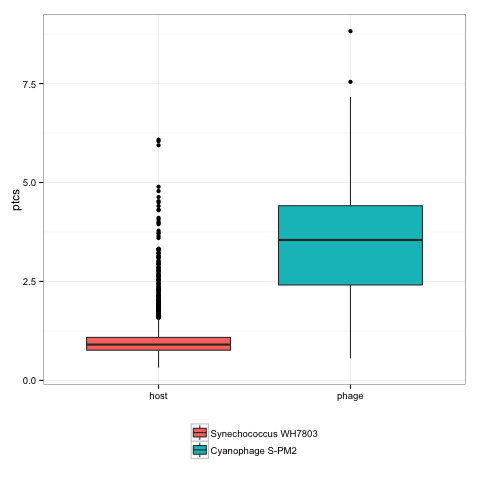

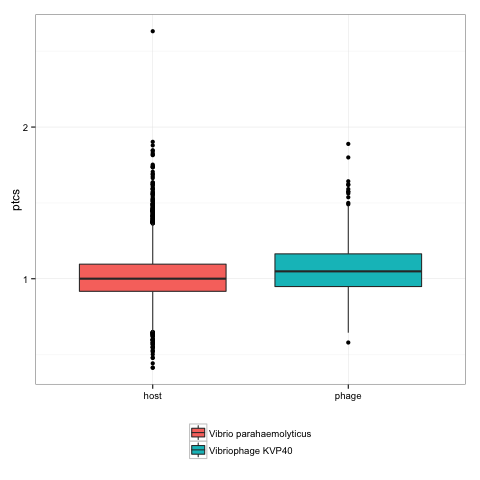

In [42]:
%%R 
categories<-c("Synechococcus WH7803","Vibrio parahaemolyticus","Mycobacterium smegmatis")
simple_names<-c("Synechococcus", "Vibrio","Mycobacterium")
p_names<-c("Cyanophage S-PM2", "Vibriophage KVP40","Mycobacteriophage Rey")

for (n in seq(1,2)){
p=paccs[n]
h=hosts[n]
name=categories[n]
pname=p_names[n]
simple_name<-simple_names[n]
    
    indiv_p<-combo%>%filter(host==p)
    indiv_p$name<-pname
    indiv_p$cat<-"phage"
    indiv_h<-combo%>%filter(host==h)
    indiv_h$name<-simple_name
    indiv_h$cat<-"host"
    indiv<-rbind(indiv_p, indiv_h)
    
    
    ggplot(indiv, aes(gene_ptcs, fill=name))+geom_density(alpha=0.3)->g
    g<-g+labs(title=name, x="ptcs", y="Density", fill="Phage or Host")+theme_bw()


ggplot(indiv, aes(cat, gene_ptcs, fill=cat))+geom_boxplot()->l
    l<-l+labs(x=NULL, y="ptcs", fill="")+theme_bw()
    l<-l+scale_fill_discrete(breaks=c("host","phage"),labels=c(categories[n],p_names[n]))+ theme(legend.position="bottom", legend.direction="vertical")
 
    
    #png(paste("boxplot_",h,".png", sep=""), height=300, width=200)
    plot(l)
    #dev.off()
    
    }

In [110]:
%%R -w 1200
out<-data.frame(product=factor(), count=integer(), genome=factor())

for (h in unique(as.factor(combo$host))){
    print(h)
    combo%>%filter(host==h)->indiv
    outliers<-calout.detect(indiv$gene_ptcs, alpha=0.05, method="boxplot")
    indiv[outliers$ind,]->io
    io[c(8)]%>%nrow%>%print
    io%>%group_by(product)%>%summarise(count=n())->proteins
    proteins$genome<-h
    out<-rbind.data.frame(out, proteins)
    }
write.table(out, file="./data/svm1/svm2_outliers.txt", quote=FALSE, sep="\t", row.names=FALSE)

[1] "Msmeg155"
[1] 146
[1] "JF937105.1"
[1] 2
[1] "VibPara"
[1] 29
[1] "NC_005083.2"
[1] 2
[1] "Syn7803"
[1] 106
[1] "NC_006820.1"
[1] 244


In [115]:
!open ./data/svm1/svm2_outliers.txt -a textedit

[1] "Msmeg155"
[1] "JF937105.1"
[1] "VibPara"
[1] "NC_005083.2"
[1] "Syn7803"
[1] "NC_006820.1"


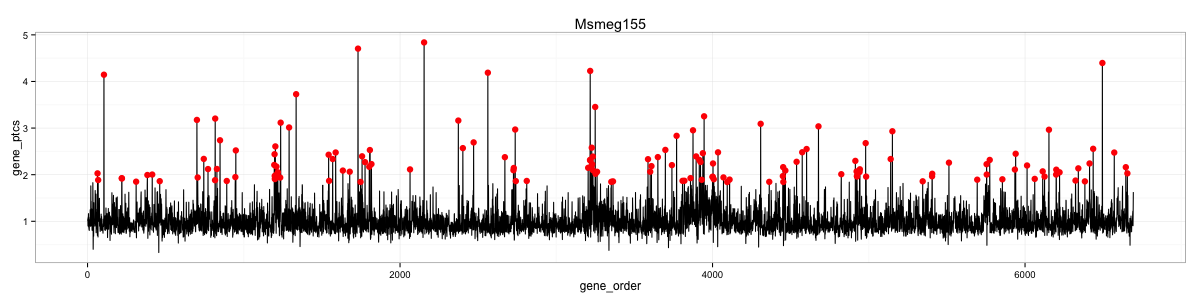

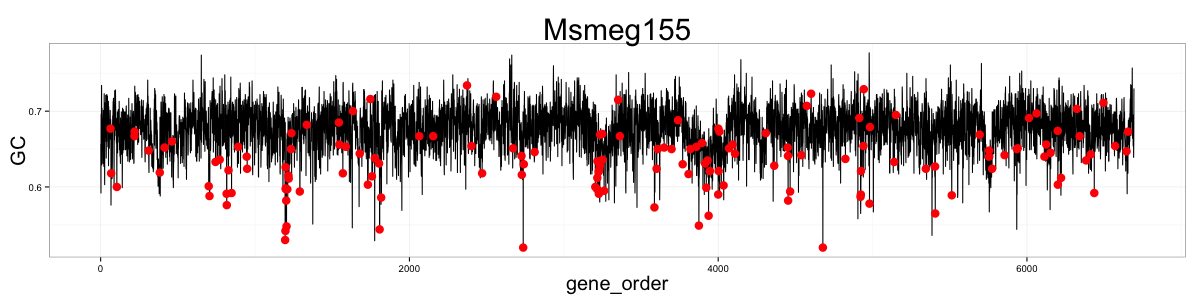

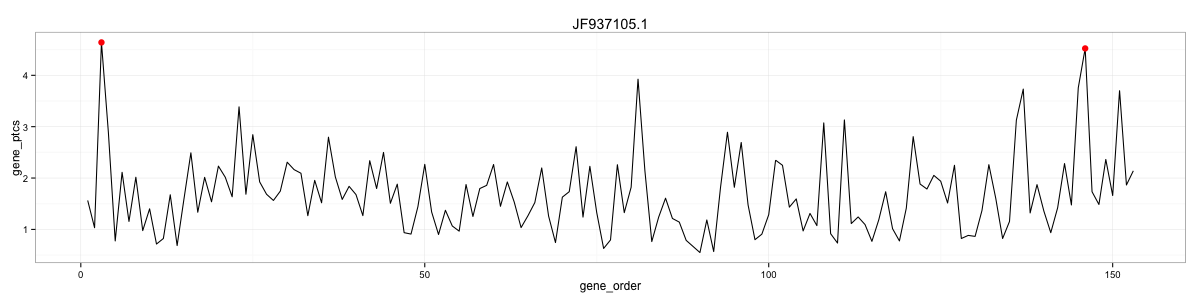

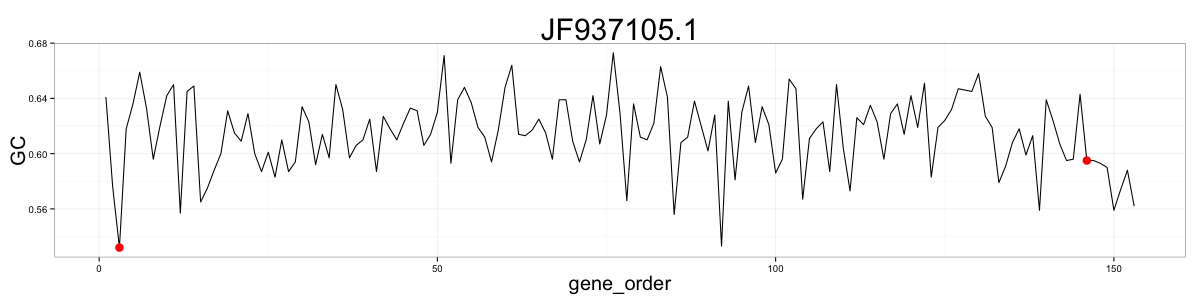

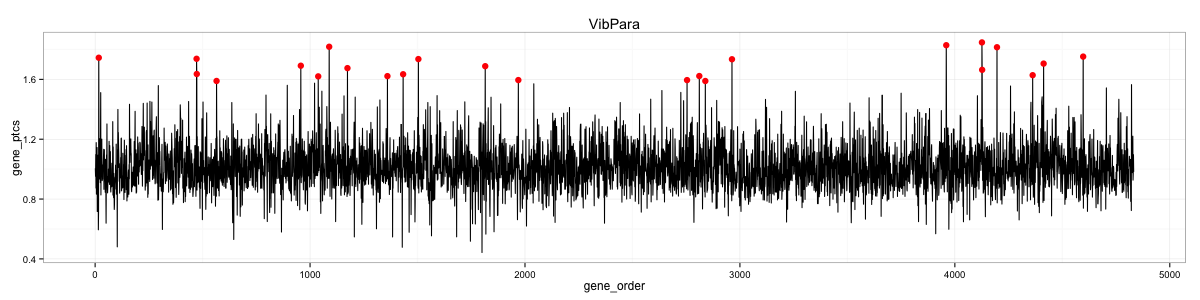

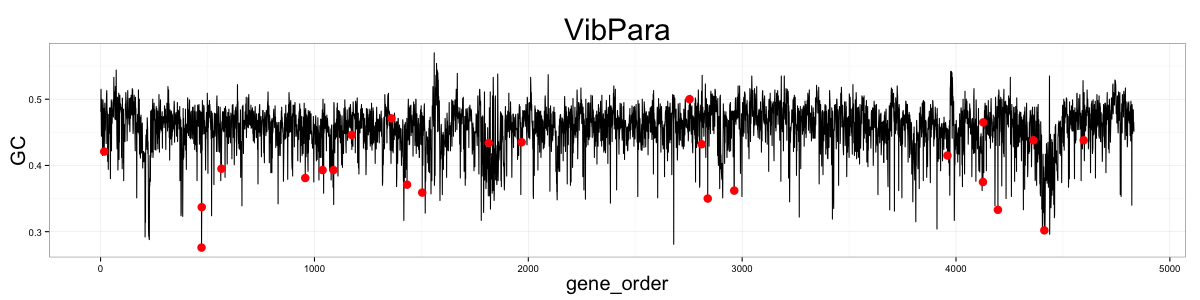

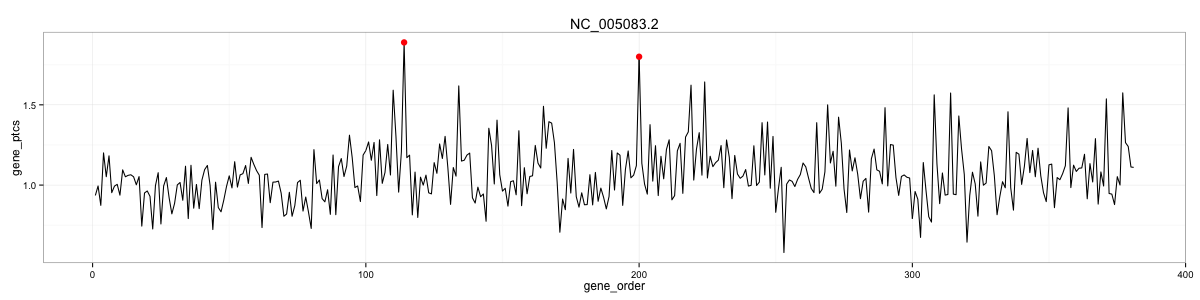

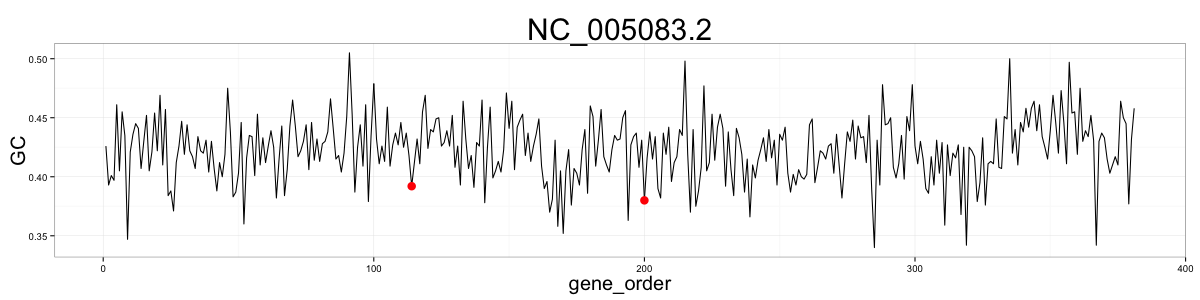

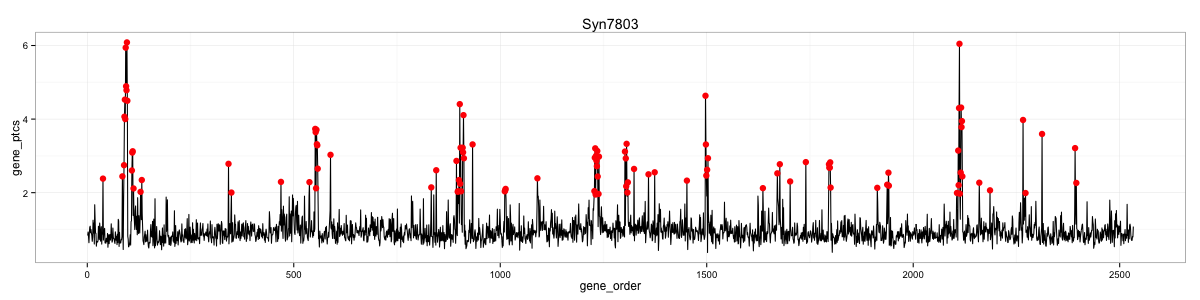

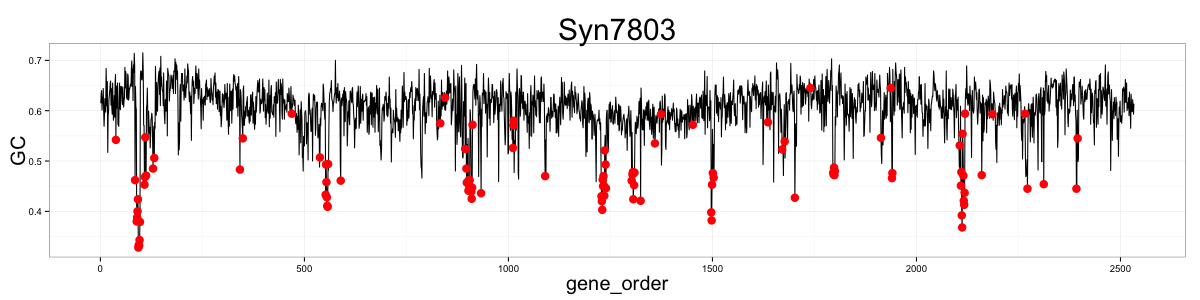

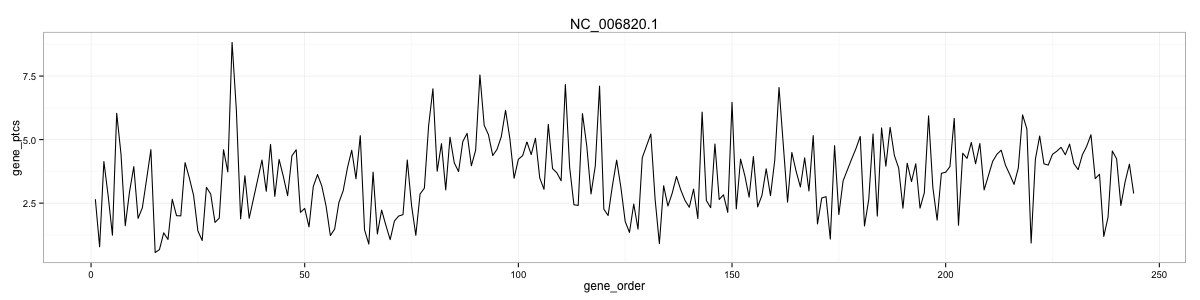

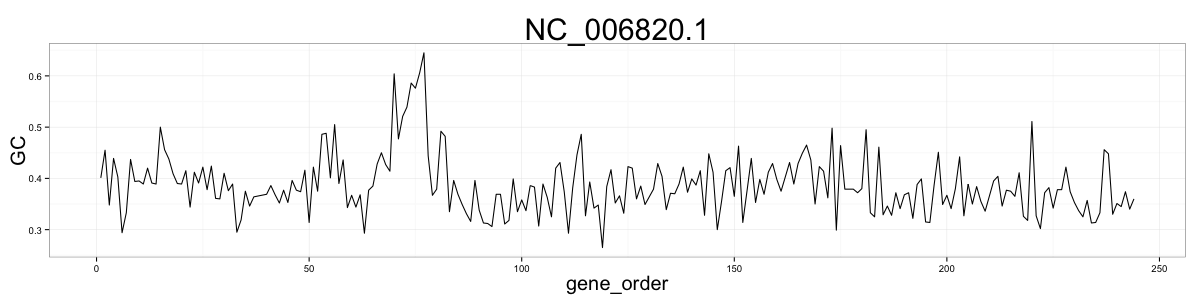

In [107]:
%%R -w 1200 -h 300
for (h in unique(as.factor(combo$host))){
    print(h)
    combo%>%filter(host==h)%>%na.omit->indiv
    outliers<-calout.detect(indiv$gene_ptcs, alpha=0.05, method="boxplot")
    indiv%>%ggplot(aes(gene_order, gene_ptcs))+geom_line()+labs(title=h)+theme_bw()->p
    p<-p+geom_point(data= indiv[outliers$ind,],color="red", cex=3)
    plot(p)
    
    location<-max(indiv$GC)+0.01
    j<-ggplot(indiv, aes(gene_order, GC))+geom_line()+
        geom_point(data= indiv[outliers$ind,],color="red", cex=4, aes(x=gene_order, y=GC))+labs(title=h)
    j<-j+theme_bw()+theme(axis.title.x = element_text(size=20), axis.title.y=element_text(size=20), title=element_text(size=25))
    plot(j)
    }

In [ ]:
%%R
for (h in unique(as.factor(combo$host))){
    print(h)
    combo%>%filter(host==h)%>%na.omit->indiv
    outliers<-calout.detect(indiv$gene_ptcs, alpha=0.05, method="boxplot")